In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (15, 5)

**Import and prepare data**

Add extra columns

In [3]:
def prepare_data(coin):
    df = pd.read_csv(f'../data/coin_{coin}.csv', index_col=0).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df['dayofweek'] = df.Date.dt.dayofweek
    df['dayofmonth'] = df.Date.dt.day
    df['year_month'] = df.Date.dt.strftime("%Y-%m")
    df['avg_daily_price']= (df.High + df.Low) / 2
    return df

**Calculate profit**

Given the provided dataframe for a specific coin, and the configuration for the frequency of the DCA plan, calculate the profit in percantage accumulated over the specified time window.

In [4]:
def calculate_profit_dca(df, frequency, purchase_year_month = '2018-01',\
                        purchase_day_of_week = 0, purchase_day_of_month = [0]):
    purchase_usd = 10
    if frequency == 'monthly':
        freq_cond = (df.dayofmonth.isin(purchase_day_of_month))
        if(31 in purchase_day_of_month):
            # Take last day of months with 30 days
            freq_cond = freq_cond | (df.Date.dt.month.isin([11,4,6,9]) & (df.dayofmonth == 30))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month)):
            # Take last day of February (29th in case of leap year)
            freq_cond = freq_cond |\
                        (df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044]) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 29))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month) or (29 in purchase_day_of_month)):     
            # In case 29 is the day, use 28 for February in non leap year
            freq_cond = freq_cond |\
                        ((~df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044])) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 28))          
    if frequency == 'weekly':
        freq_cond = (df.dayofweek == purchase_day_of_week)

    purchase = df[(df.year_month >= purchase_year_month) & freq_cond]
    purchased_amount = (purchase_usd/purchase.High).sum()
    investment_amount = purchase_usd * len(purchase)
    investment_value = df[-1:].High * purchased_amount
    return (investment_value / investment_amount)*100

The considered coins

In [5]:
coins = ['Bitcoin', 'Ethereum', 'Polkadot']

Calculate profits for each day of the week, given a weekly DCA

In [6]:
day_of_week_profit = {'day': []}
for i in range(0,7):
    day_of_week_profit['day'].append(i)

for coin in coins:
    df = prepare_data(coin)
    day_of_week_profit[coin] = []
    print(f"Calculating profit for coin {coin}. Sample size {len(df)}...")
    for i in range(0,7):    
        day_of_week_profit[coin].append(calculate_profit_dca(df, 'weekly', purchase_day_of_week=i).iloc[0])

Calculating profit for coin Bitcoin. Sample size 2991...
Calculating profit for coin Ethereum. Sample size 2160...
Calculating profit for coin Polkadot. Sample size 320...


In [7]:
profit_df = pd.DataFrame(day_of_week_profit).set_index('day')

Let's plot the values

In [8]:
profit_df

,Bitcoin,Ethereum,Polkadot
day,,,
0,404.977584,868.514501,174.849991
1,405.580905,873.272465,174.424633
2,406.145920,874.629746,174.207825
3,405.935406,875.476597,172.387370
4,408.784580,882.230901,180.397854
5,408.044080,878.045999,177.033334
6,407.610818,874.692619,178.488091


<AxesSubplot:xlabel='day'>

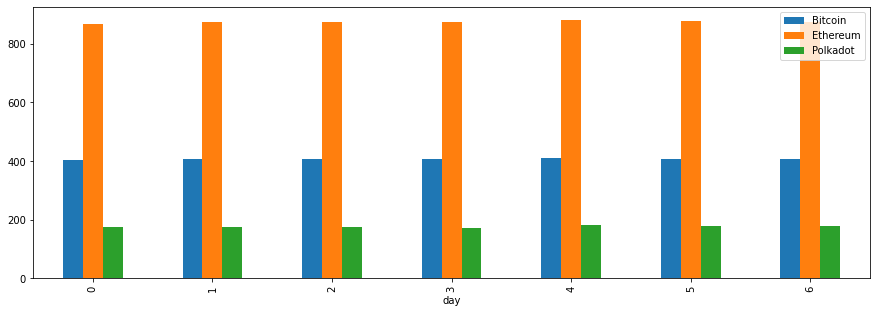

In [9]:
(profit_df).plot(kind='bar')

We standardize the values to cancel out the scale of the different coins and obtain a more visually intuitive reppresentation.

<AxesSubplot:xlabel='day of week', ylabel='z-score profit'>

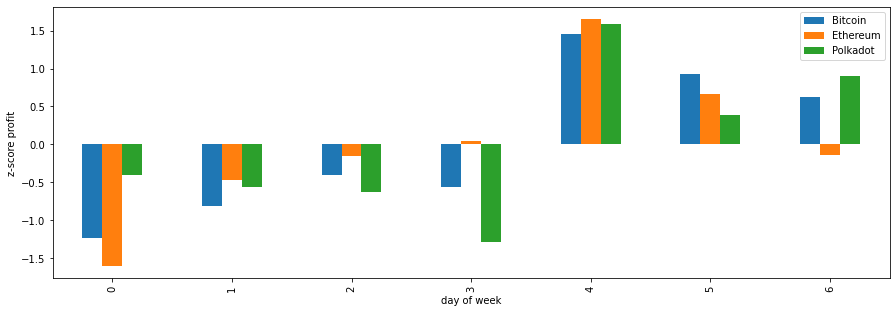

In [10]:
plt = ((profit_df - profit_df.mean())/profit_df.std()).plot(kind='bar', ylabel='z-score profit', xlabel='day of week')
plt.get_figure().savefig("../images/weekly.jpeg", bbox_inches = 'tight',
    pad_inches = 0.2)
plt

The plot shows that Friday is the day where all coins provide the most profits.
Let's calcutate the best day for a portfolio comprised of these coins in different shares.
It is after all not correct to give all coins the same importance. Furthermore, some coins represent a larger part of the portfolio and we are therefore interested in giving these priority.
We use the rank for the days and maximise the sum.
We give each coin a weight and find the maximum.

In [11]:
profit_df.rank()\
         .transpose()\
         .apply(lambda x: (x.Bitcoin*40)+(x.Ethereum*40)+(x.Polkadot*20)).idxmax()

4

The formula confirmas that the day that maximises the profits is Friday